# Windowing
I will try to apply the following windowing to the images:

- Brain Matter window : W:80 L:40
- Blood/subdural window: W:130-300 L:50-100
- Soft tissue window: W:350–400 L:20–60
- Bone window: W:2800 L:600
- Grey-white differentiation window: W:8 L:32 or W:40 L:40


Source: https://radiopaedia.org/articles/ct-head-an-approach?lang=gb

In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_DIR = '/data/cmpe257-02-fa2019/team-1-meerkats/rsna-intracranial-hemorrhage-detection/'
!ls $DATA_DIR

stage_2_sample_submission.csv  stage_2_test  stage_2_train  stage_2_train.csv


In [3]:
# dcm processing

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img


In [4]:
!ls $DATA_DIR/stage_2_train | head

ID_000012eaf.dcm
ID_000039fa0.dcm
ID_00005679d.dcm
ID_00008ce3c.dcm
ID_0000950d7.dcm
ID_0000aee4b.dcm
ID_0000ca2f6.dcm
ID_0000f1657.dcm
ID_000178e76.dcm
ID_00019828f.dcm
ls: write error: Broken pipe


In [5]:
dcm = pydicom.dcmread(DATA_DIR+'stage_2_train/'+'ID_9d9cc6b01.dcm')

In [6]:
dcm

(0008, 0018) SOP Instance UID                    UI: ID_9d9cc6b01
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_acad267f'
(0020, 000d) Study Instance UID                  UI: ID_9a838f31f2
(0020, 000e) Series Instance UID                 UI: ID_a6a2721356
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '24.6686845', '204.589253']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '0.945518576', '-0.325568154']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         U

In [7]:
img = dcm.pixel_array
img.shape

(512, 512)

In [8]:
brain_matter_img = window_image(dcm, 40, 80) # Brain Matter
subdural_blood_img = window_image(dcm, 80, 200) # Blood/subdural window
soft_tissue_img = window_image(dcm, 40, 380) # Soft tissue window
bone_img = window_image(dcm, 600, 2800) # Bone window
grey_white_diff_window = window_image(dcm, 32, 8) # Grey-white differentiation window


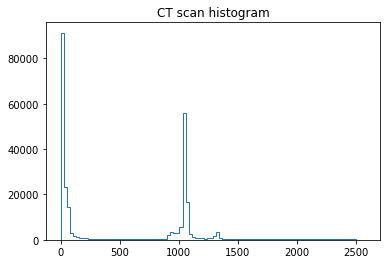

In [9]:
import matplotlib.pyplot as plt
_ = plt.hist(img.flatten(), bins=100, histtype='step')  # arguments are passed to np.histogram
plt.title("CT scan histogram")

plt.show()

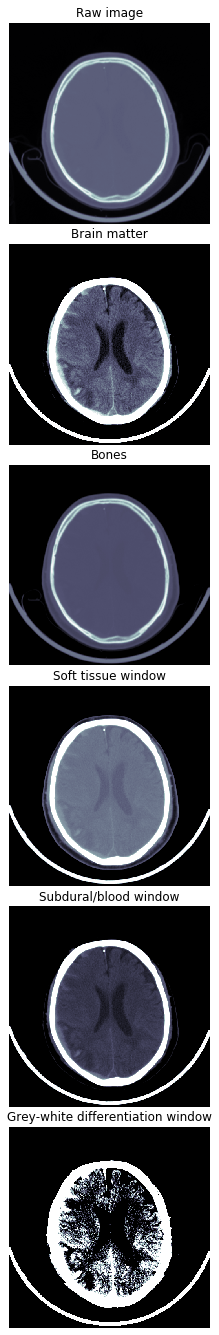

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, sharex='col', figsize=(10,24), gridspec_kw={'hspace': 0.1, 'wspace': 0})

ax1.set_title('Raw image')
im1 = ax1.imshow(img,  cmap=plt.cm.bone)

ax2.set_title('Brain matter')
im2 = ax2.imshow(brain_matter_img, cmap=plt.cm.bone)

ax3.set_title('Bones')
im3 = ax3.imshow(bone_img, cmap=plt.cm.bone)

ax4.set_title('Soft tissue window')
im4 = ax4.imshow(soft_tissue_img, cmap=plt.cm.bone)

ax5.set_title('Subdural/blood window')
im5 = ax5.imshow(subdural_blood_img, cmap=plt.cm.bone)

ax6.set_title('Grey-white differentiation window')
im6 = ax6.imshow(grey_white_diff_window, cmap=plt.cm.bone)


for ax in fig.axes:
    ax.axis("off")

In [12]:
bsb_window(dcm).shape

(512, 512, 3)